In [91]:
import pandas as pd
import urllib.parse
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:

df_main = pd.read_csv("properties_data.csv", low_memory=False)
df = df_main[["id","location","Zip","Type","Subtype",
    "Price","Transaction Type","Bedrooms","Living area","Kitchen type",
    "Furnished","How many fireplaces?","Terrace","Terrace surface",
    "Garden","Garden surface","Surface of the plot","Number of frontages",
    "Swimming pool","Building condition","Primary energy consumption"]]
df = df.set_index("id")
df = df.drop(df[df["Type"]=="house group"].index)
df = df.drop(df[df["Type"]=="apartment group"].index)
df = df.rename(columns={
    'location' :'Locality',
    'Transaction Type' : 'Type of sale',
    'Type' :'Type of property',
    'Subtype' : 'Subtype of property',
    'Number of frontages': 'Number of facades',
    'Bedrooms':'Number of rooms',
    'Surface of the plot' :'Surface of the land',
    'Kitchen type' : 'Fully equipped kitchen',
    'How many fireplaces?' : 'Open fire'
})
 
#put the columns in a specific order'
df = df.reindex(columns=['Locality',"Zip", 'Type of property', 'Subtype of property',
                         'Type of sale', 'Price',
                         'Building condition','Building Cond. values',
                         'Number of facades', 'Number of rooms', 
                         'Living area',
                         'Furnished','Fully equipped kitchen','Kitchen values',
                         'Surface of the land',
                         'Primary energy consumption','Energy_classes' ,
                         'Terrace', 'Terrace surface','Garden','Garden surface',
                         'Open fire', 'Swimming pool'])

df_houses = df[df['Type of property'] == 'house']
df_apartments = df[df['Type of property'] == 'apartment']

all_missing_value_df = df.isnull().mean() * 100
houses_missing_value_df = df_houses.isnull().mean() * 100
apartments_missing_value_df = df_apartments.isnull().mean() * 100
pd.set_option('display.float_format', '{:.2f}'.format)
print("all_missing_value")
print(all_missing_value_df)
print("")
print("houses_missing_value")
print(houses_missing_value_df)
print("")
print("apartments_missing")
print(apartments_missing_value_df)

def clean_and_convert(column):
    column = column.apply(lambda x: re.sub('\D+', '', str(x)))
    column = column.replace('', np.nan)
    return column

df['Living area'] = clean_and_convert(df['Living area'])
df['Terrace surface'] = clean_and_convert(df['Terrace surface'])
df['Garden surface'] = clean_and_convert(df['Garden surface'])
df['Surface of the land'] = clean_and_convert(df['Surface of the land'])
df['Primary energy consumption'] = clean_and_convert(df['Primary energy consumption'])
df['Locality'] = df['Locality'].apply(urllib.parse.unquote)

# missing_value_df = df.isnull().mean() * 100
# missing_value_df

conditions = [
    (df['Garden']== "Yes"),
    (df["Garden"].isna()) & (df["Garden surface"].isna()),
    (df["Garden surface"].notna())
    ]
values = [1, 0, 1]
df['Garden'] = np.select(conditions, values)

df.loc[(df["Garden"] == 0 ) & (df["Garden surface"].isna()), 'Garden surface'] = 0
conditions = [
    (df['Terrace']== "Yes"),
    (df["Terrace"].isna()) & (df["Terrace surface"].isna()),
    (df["Terrace surface"].notna())
    ]
values = [1, 0, 1]
df['Terrace'] = np.select(conditions, values)

df.loc[(df["Terrace"] == 0 ) & (df["Terrace surface"].isna()), 'Terrace surface'] = 0
def nan_replacement(column):
    column = column.replace("Yes",1)
    column = column.replace("No",0)
    column = column.replace('', np.nan).fillna(0)
    return column

df['Furnished'] = nan_replacement(df['Furnished'])
df['Swimming pool'] = nan_replacement(df['Swimming pool'])
df['Open fire'] = nan_replacement(df['Open fire'])
df["Price"] = df["Price"].astype(int)
df = df.astype({"Price":"int",
                "Number of rooms":"float",
                "Living area":"float",
                "Terrace surface":"float",
                "Garden surface":"float",
                "Surface of the land":"float",
                "Number of facades":"float",
                "Primary energy consumption":"float"})
# Mapping dictionary for replacing values in the "kitchen" column
kitchen_mapping = {
    np.nan: -1,
    'Not installed': 0,
    'Installed': 1,
    'Semi equipped': 2,
    'Hyper equipped': 3,
    'USA uninstalled' :0,
    'USA installed': 1,
    'USA semi equipped': 2,
    'USA hyper equipped' :3
}
# Replace values in the "Kitchen type" column with corresponding numbers and create a new column called "Kitchen values"
df['Kitchen values'] = df['Fully equipped kitchen'].map(kitchen_mapping).fillna(df['Fully equipped kitchen']).astype(int)
building_cond_mapping = {
    np.nan: -1,
    'To restore': 0,
    'To be done up': 2,
    'Just renovated': 3,
    'To renovate': 1,
    'Good': 3,
    'As new' :4
}

df['Building Cond. values'] = df['Building condition'].map(building_cond_mapping).fillna(df['Building condition']).astype(int)
df = df.drop(df[df["Living area"].isna()].index)
#Missing values fillied with 1
df["Primary energy consumption"] = np.where((df["Primary energy consumption"] != int) & (df["Primary energy consumption"] == ""), 0, df["Primary energy consumption"])
df["Primary energy consumption"] = df["Primary energy consumption"].replace("",np.nan).fillna(-1).astype(int)

#New column with energy classes 
conditions = [
    (df['Primary energy consumption']==-1),
    (df['Primary energy consumption']>=1)&(df['Primary energy consumption']<100),
    (df['Primary energy consumption']>=100)&(df['Primary energy consumption']<200),
    (df['Primary energy consumption']>=200)&(df['Primary energy consumption']<300),
    (df['Primary energy consumption']>=300)&(df['Primary energy consumption']<400),
    (df['Primary energy consumption']>=400)&(df['Primary energy consumption']<500),
    (df['Primary energy consumption']>=500)&(df['Primary energy consumption']<600),
    (df['Primary energy consumption']>=600)
]

values = [-1,7, 6, 5, 4, 3, 2, 1]

df['Energy_classes'] = np.select(conditions, values)
print(f"The DataFrame has {df.shape[0]} rows and {df.shape[1]} columns.")
# print(missing_value_df)
df.to_csv("clean_data.csv")

In [95]:
df_houses = df[df['Type of property'] == 'house']
df_apartments = df[df['Type of property'] == 'apartment']

all_missing_value_df = df.isnull().mean() * 100
houses_missing_value_df = df_houses.isnull().mean() * 100
apartments_missing_value_df = df_apartments.isnull().mean() * 100

print("all_missing_value")
print(all_missing_value_df)
print("")
print("houses_missing_value")
print(houses_missing_value_df)
print("")
print("apartments_missing")
print(apartments_missing_value_df)

all_missing_value
Locality                      0.00
Zip                           0.00
Type of property              0.00
Subtype of property           0.00
Type of sale                  0.00
Price                         0.00
Building condition           15.77
Building Cond. values         0.00
Number of facades            23.31
Number of rooms               1.84
Living area                   0.00
Furnished                     0.00
Fully equipped kitchen       21.81
Kitchen values                0.00
Surface of the land          49.83
Primary energy consumption    0.00
Energy_classes                0.00
Terrace                       0.00
Terrace surface              23.89
Garden                        0.00
Garden surface               12.25
Open fire                     0.00
Swimming pool                 0.00
dtype: float64

houses_missing_value
Locality                      0.00
Zip                           0.00
Type of property              0.00
Subtype of property           0.00


In [96]:
df['Price of square meter'] = df['Price'] / df['Living area']
df['Price of square meter'] = df['Price of square meter'].round(2)



In [97]:
def get_province(zip_code):
    if 1000 <= zip_code <= 1299:
        return 'Brussels Capital Region'
    elif 1300 <= zip_code <= 1499:
        return 'Walloon Brabant'
    elif 1500 <= zip_code <= 1999 or 3000 <= zip_code <= 3499:
        return 'Flemish Brabant'
    elif 2000 <= zip_code <= 2999:
        return 'Antwerp'
    elif 3500 <= zip_code <= 3999:
        return 'Limburg'
    elif 4000 <= zip_code <= 4999:
        return 'Liège'
    elif 5000 <= zip_code <= 5999:
        return 'Namur'
    elif 6000 <= zip_code <= 6599 or 7000 <= zip_code <= 7999:
        return 'Hainaut'
    elif 6600 <= zip_code <= 6999:
        return 'Luxembourg'
    elif 8000 <= zip_code <= 8999:
        return 'West Flanders'
    elif 9000 <= zip_code <= 9999:
        return 'East Flanders'
    else:
        return 'Unknown'
        
df['Province'] = df['Zip'].apply(get_province)


df = df.reindex(columns=['Locality',"Zip",'Province', 
                         'Type of property', 'Subtype of property',
                         'Type of sale', 'Price','Price of square meter',
                         'Building condition','Building Cond. values',
                         'Number of facades', 'Number of rooms', 
                         'Living area',
                         'Furnished','Fully equipped kitchen','Kitchen values',
                         'Surface of the land',
                         'Primary energy consumption','Energy_classes' ,
                         'Terrace', 'Terrace surface','Garden','Garden surface',
                         'Open fire', 'Swimming pool'])

df.to_csv("clean_data.csv")

In [98]:
# Define provinces in each region
flanders_provinces = ['Flemish Brabant','Antwerp','Limburg','West Flanders','East Flanders']
wallonia_provinces = ['Walloon Brabant','Liège','Namur','Hainaut','Luxembourg']
brussels_provinces = ['Brussels Capital Region']

df_flanders = df[df['Province'].isin(flanders_provinces)]
df_wallonia = df[df['Province'].isin(wallonia_provinces)]
df_brussels = df[df['Province'].isin(brussels_provinces)]


In [99]:
def calculate_metrics(region_df):
    return region_df.groupby('Zip').agg(Avg_Price=('Price','mean'),
                                        Median_Price=('Price','median'),
                                        Price_Per_Sq_Meter=('Price of square meter','mean'))

In [100]:
belgium_metrics = calculate_metrics(df)
flanders_metrics = calculate_metrics(df_flanders)
wallonia_metrics = calculate_metrics(df_wallonia)
brussels_metrics = calculate_metrics(df_brussels)


most_expensive_belgium = belgium_metrics['Avg_Price'].idxmax()
least_expensive_belgium = belgium_metrics['Avg_Price'].idxmin()

most_expensive_flanders = flanders_metrics['Avg_Price'].idxmax()
least_expensive_flanders = flanders_metrics['Avg_Price'].idxmin()

most_expensive_wallonia = wallonia_metrics['Avg_Price'].idxmax()
least_expensive_wallonia = wallonia_metrics['Avg_Price'].idxmin()

most_expensive_brussels = brussels_metrics['Avg_Price'].idxmax()
least_expensive_brussels = brussels_metrics['Avg_Price'].idxmin()

In [101]:
pd.set_option('display.float_format', '{:.2f}'.format)

print(f'Most expensive municipality in Belgium: {most_expensive_belgium}')
print(belgium_metrics.loc[most_expensive_belgium])
print(f'Least expensive municipality in Belgium: {least_expensive_belgium}')
print(belgium_metrics.loc[least_expensive_belgium])

print(f'Most expensive municipality in Flanders: {most_expensive_flanders}')
print(flanders_metrics.loc[most_expensive_flanders])
print(f'Least expensive municipality in Flanders: {least_expensive_flanders}')
print(flanders_metrics.loc[least_expensive_flanders])

print(f'Most expensive municipality in Wallonia: {most_expensive_wallonia}')
print(wallonia_metrics.loc[most_expensive_wallonia])
print(f'Least expensive municipality in Wallonia: {least_expensive_wallonia}')
print(wallonia_metrics.loc[least_expensive_wallonia])

print(f'Most expensive municipality in Brussels: {most_expensive_brussels}')
print(brussels_metrics.loc[most_expensive_brussels])
print(f'Least expensive municipality in Brussels: {least_expensive_brussels}')
print(brussels_metrics.loc[least_expensive_brussels])


Most expensive municipality in Belgium: 8902
Avg_Price            2500000.00
Median_Price         2500000.00
Price_Per_Sq_Meter      3333.33
Name: 8902, dtype: float64
Least expensive municipality in Belgium: 5680
Avg_Price            49950.00
Median_Price         49950.00
Price_Per_Sq_Meter     445.40
Name: 5680, dtype: float64
Most expensive municipality in Flanders: 8902
Avg_Price            2500000.00
Median_Price         2500000.00
Price_Per_Sq_Meter      3333.33
Name: 8902, dtype: float64
Least expensive municipality in Flanders: 9970
Avg_Price            168000.00
Median_Price         168000.00
Price_Per_Sq_Meter     1768.42
Name: 9970, dtype: float64
Most expensive municipality in Wallonia: 1380
Avg_Price            1396184.35
Median_Price         1195000.00
Price_Per_Sq_Meter      3812.90
Name: 1380, dtype: float64
Least expensive municipality in Wallonia: 5680
Avg_Price            49950.00
Median_Price         49950.00
Price_Per_Sq_Meter     445.40
Name: 5680, dtype: float64


/tmp/ipykernel_199/859912603.py:49: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Region', y='Price', hue='Status', data=melted, ci=None)


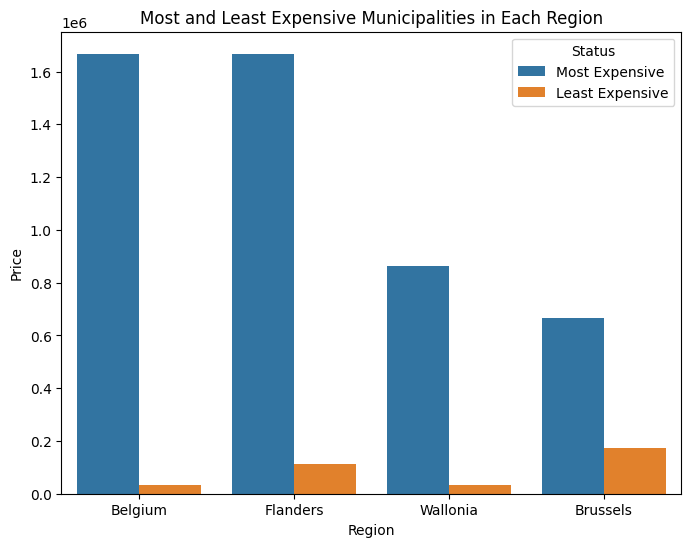

In [102]:
'''# Retrieve rows from the metric DataFrames
belgium_most_expensive = belgium_metrics.loc[[most_expensive_belgium]].copy()
belgium_least_expensive = belgium_metrics.loc[[least_expensive_belgium]].copy()
flanders_most_expensive = flanders_metrics.loc[[most_expensive_flanders]].copy()
flanders_least_expensive = flanders_metrics.loc[[least_expensive_flanders]].copy()
wallonia_most_expensive = wallonia_metrics.loc[[most_expensive_wallonia]].copy()
wallonia_least_expensive = wallonia_metrics.loc[[least_expensive_wallonia]].copy()
brussels_most_expensive = brussels_metrics.loc[[most_expensive_brussels]].copy()
brussels_least_expensive = brussels_metrics.loc[[least_expensive_brussels]].copy()

# Assign 'Region' and 'Status' columns
belgium_most_expensive['Region'] = 'Belgium'
belgium_most_expensive['Status'] = 'Most Expensive'
belgium_least_expensive['Region'] = 'Belgium'
belgium_least_expensive['Status'] = 'Least Expensive'

flanders_most_expensive['Region'] = 'Flanders'
flanders_most_expensive['Status'] = 'Most Expensive'
flanders_least_expensive['Region'] = 'Flanders'
flanders_least_expensive['Status'] = 'Least Expensive'

wallonia_most_expensive['Region'] = 'Wallonia'
wallonia_most_expensive['Status'] = 'Most Expensive'
wallonia_least_expensive['Region'] = 'Wallonia'
wallonia_least_expensive['Status'] = 'Least Expensive'

brussels_most_expensive['Region'] = 'Brussels'
brussels_most_expensive['Status'] = 'Most Expensive'
brussels_least_expensive['Region'] = 'Brussels'
brussels_least_expensive['Status'] = 'Least Expensive'

# Concatenate the results into one dataframe
all_results = pd.concat([
    belgium_most_expensive, belgium_least_expensive,
    flanders_most_expensive, flanders_least_expensive,
    wallonia_most_expensive, wallonia_least_expensive,
    brussels_most_expensive, brussels_least_expensive
])

# Reset index
all_results.reset_index(inplace=True)

# Melt the dataframe to make it suitable for seaborn
melted = all_results.melt(id_vars=['Zip', 'Region', 'Status'], value_vars=['Avg_Price', 'Median_Price', 'Price_Per_Sq_Meter'], 
                          var_name='Metric', value_name='Price')

# Create a bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x='Region', y='Price', hue='Status', data=melted, ci=None)
plt.title('Most and Least Expensive Municipalities in Each Region')
plt.xlabel('Region')
plt.ylabel('Price')
plt.show()'''
